In [1]:
import sys
sys.path.append("../")
import re
from os.path import join
from IPython.display import display
import h5py
import json
import inspect
import os

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('text', usetex=False)

import faiss
from PIL import Image 
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder, VisionDataset
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import scipy

from lolip.models.vari_torch_model import VariTorchModel
import lolip.models.torch_utils.archs as archs
from lolip.variables import auto_var

fontsize=20
%load_ext autoreload
%autoreload 2

(CVXPY) Jan 21 02:27:13 PM: Encountered unexpected exception importing solver GUROBI:
ImportError('libgurobi100.so: cannot open shared object file: No such file or directory')
(CVXPY) Jan 21 02:27:13 PM: Encountered unexpected exception importing solver GUROBI:
ImportError('libgurobi100.so: cannot open shared object file: No such file or directory')


In [2]:
auto_var.set_variable_value("random_seed", 0)

data = {}
for i in tqdm(range(10)):
    ds_name = f"mnistwo{i}"
    trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", ds_name)
    oodX = np.concatenate((rest[0], rest[1]), axis=0)
    
    fet_size = int(np.prod(trnX.shape[1:]).astype(int))
    index = faiss.IndexFlatL2(fet_size)
    index.add(trnX.reshape(len(trnX), -1))
    D, I = index.search(oodX.reshape(len(oodX), -1), 1)
    D = np.sqrt(D[:, 0].reshape(-1))
    
    res = joblib.load(f"../results/oos_repr/cwl2-128-{ds_name}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl")
    #res = joblib.load(f"../results/oos_repr/cwl2-128-{ds_name}-70-2.0-0.01-trades6ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl")
    ood_preds = np.concatenate((res['oos_trn_pred'], res['oos_tst_pred']))
    
    data[ds_name] = (D.mean(), (ood_preds == trny[I[:, 0]]).mean())
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

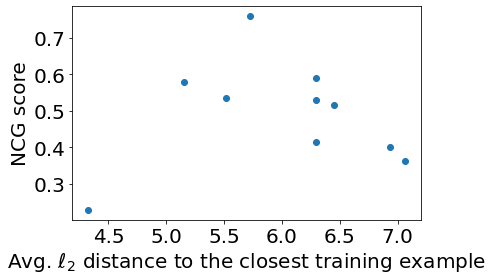

In [4]:
a, b = [], []
for i in tqdm(range(10)):
    ds_name = f"mnistwo{i}"
    a.append(data[ds_name][0])
    b.append(data[ds_name][1])
plt.scatter(a, b)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("NCG score", fontsize=fontsize)
plt.xlabel("Avg. $\ell_2$ distance to the closest training example", fontsize=fontsize)
plt.tight_layout()
plt.savefig("./figs/dset_dist_scatter/pixel_mnist.png")

In [ ]:
scipy.stats.pearsonr(a, b)

In [6]:
auto_var.set_variable_value("random_seed", 0)

data = {}
for i in tqdm(range(10)):
    ds_name = f'calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl'
    trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", ds_name)
    oodX = np.concatenate((rest[0], rest[1]), axis=0)
    
    fet_size = int(np.prod(trnX.shape[1:]).astype(int))
    index = faiss.IndexFlatL2(fet_size)
    index.add(trnX.reshape(len(trnX), -1))
    D, I = index.search(oodX.reshape(len(oodX), -1), 1)
    D = np.sqrt(D[:, 0].reshape(-1))
    
    res = joblib.load(f"../results/out_of_sample_mnist_bak/cwl2-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-1.0-0.01-ce-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl")
    #res = joblib.load(f"../results/oos_repr/cwl2-128-{ds_name}-70-2.0-0.01-trades6ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl")
    ood_preds = np.concatenate((res['oos_trn_pred'], res['oos_tst_pred']))
    
    data[ds_name] = (D.mean(), (ood_preds == trny[I[:, 0]]).mean())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

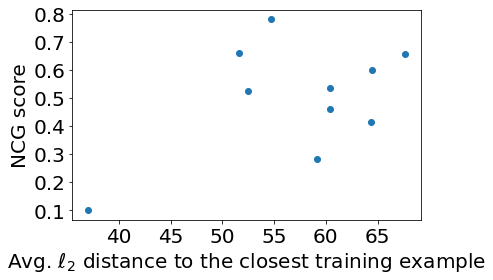

In [9]:
a, b = [], []
for i in tqdm(range(10)):
    ds_name = f'calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl'
    a.append(data[ds_name][0])
    b.append(data[ds_name][1])
plt.scatter(a, b)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("NCG score", fontsize=fontsize)
plt.xlabel("Avg. $\ell_2$ distance to the closest training example", fontsize=fontsize)
plt.tight_layout()
plt.savefig("./figs/dset_dist_scatter/feature_mnist.png")

In [8]:
scipy.stats.pearsonr(a, b)

PearsonRResult(statistic=0.48689491845194544, pvalue=0.15352517968887577)

In [6]:
def get_closet_img(img_path, index, model=None, device="cpu"):
    tstx = transform(pil_loader(img_path))
    if model is None:
        tst_fet = tstx.unsqueeze(0).flatten().cpu().detach().numpy().reshape(1, -1)
    else:
        tst_fet = model(tstx.unsqueeze(0).to(device)).flatten().cpu().detach().numpy().reshape(1, -1)
    D, I = index.search(tst_fet, k=1)
    #return pil_loader(res['img_paths'][I[0][0]])
    return I[0][0]

def prediction_with_model(arch_name, model_path, loader, n_classes):
    arch_fn = getattr(archs, arch_name)
    arch_params = dict(n_classes=n_classes, n_channels=3)
    if 'n_features' in inspect.getfullargspec(arch_fn)[0]:
        arch_params['n_features'] = trnX.shape[1:]
    model = arch_fn(**arch_params)
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    ret = []
    for X, _ in tqdm(loader):
        ret.append(model(X).detach().cpu().numpy())
    return np.concatenate(ret, 0)

In [7]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty, rest = auto_var.get_var_with_argument("dataset", "mnistwo9")

In [17]:
fet_size = int(np.prod(trnX.shape[1:]).astype(int))
index = faiss.IndexFlatL2(fet_size)
index.add(trnX.reshape(len(trnX), -1))
D, I = index.search(rest[0].reshape(len(rest[0]), -1), 1)

In [34]:
im = (rest[0][0, :, :, 0] * 255).astype(np.uint8)
im2 = (trnX[I[0, 0], :, :, 0] * 255).astype(np.uint8)
Image.fromarray(im).save("./figs/mnist_examples/0.png")
Image.fromarray(im2).save("./figs/mnist_examples/tr_0.png")
display(Image.fromarray(im))
display(Image.fromarray(im2))